### Probna ANN za PICOSEC-MM - novo

In [1]:
%matplotlib inline
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import IPython
from scipy.stats import norm

In [2]:
# jednostavna duboka mreža
modelSimple = tf.keras.Sequential([
    tf.keras.Input(shape = (64,)),
    tf.keras.layers.Dense(units = 32, activation = tf.keras.layers.LeakyReLU(negative_slope=0.05)),
    tf.keras.layers.Dense(units = 128, activation = tf.keras.layers.LeakyReLU(negative_slope=0.02)),
    tf.keras.layers.Dense(units = 32, activation = tf.keras.layers.LeakyReLU(negative_slope=0.01)),
    tf.keras.layers.Dense(units = 16),
    tf.keras.layers.Dense(units = 1),
])
modelSimple.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.01), loss = 'mean_squared_error', )

# složenija, konvolucijska mreža
modelConv = tf.keras.Sequential([
    tf.keras.Input(shape = (64,)),
    tf.keras.layers.Reshape((64, 1)),  # reshape to (samples, channels)
    tf.keras.layers.Conv1D(128, kernel_size=5, activation='relu'),
    tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)  # output timing index
])
modelConv.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error')

In [3]:
modelSimple.summary()
modelConv.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,977 (42.88 KB)

 Trainable params: 10,977 (42.88 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 64, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 60, 128)             │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 58, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 58, 64)              │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3712)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │           3,713 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,281 (130.00 KB)

 Trainable params: 33,281 (130.00 KB)

 Non-trainable params: 0 (0.00 B)

#### Run353

Priprema dataseta:

In [4]:
datasetPath = IPython.extract_module_locals()[1]["__vsc_ipynb_file__"][:-13] + '\datasets\compiled\Run353\\1.3.1'
datasetBuilder = tfds.builder_from_directory(datasetPath)
trainingDataset = datasetBuilder.as_dataset(split = 'train[:60%]')
testingDataset = datasetBuilder.as_dataset(split = 'train[60%:99%]')

In [5]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs['loss'] <= 4e-5:
            self.model.stop_training = True
            print("\nReached loss of 4e-5, stopped training!") 

In [6]:
training_signalData = []
training_timeLabel = []
training_SAT = []
training_mcp = []
training_t0mm = []
for event in trainingDataset:
    training_signalData.append(event['signal_data'])
    training_timeLabel.append(event['t_mm']-event['t_0mm'])
    training_mcp.append(event['t_mcp'])
    training_SAT.append(event['sat'])
    training_t0mm.append(event['t_0mm'])
training_signalData = np.array(training_signalData)
training_timeLabel = np.array(training_timeLabel)
training_mcp = np.array(training_mcp)
training_SAT = np.array(training_SAT)
training_t0mm = np.array(training_t0mm)

testing_signalData = []
testing_timeLabel = []
testing_SAT = []
testing_mcp = []
testing_t0mm = []
testing_diff = []
for event in testingDataset:
    testing_signalData.append(event['signal_data'])
    testing_timeLabel.append(event['t_mm']-event['t_0mm'])
    testing_mcp.append(event['t_mcp'])
    testing_SAT.append(event['sat'])
    testing_t0mm.append(event['t_0mm'])
    testing_diff.append(event['t_mm']-event['t_mcp'])
testing_signalData = np.array(testing_signalData)
testing_timeLabel = np.array(testing_timeLabel)
testing_mcp = np.array(testing_mcp)
testing_SAT = np.array(testing_SAT)
testing_t0mm = np.array(testing_t0mm)
testing_diff = np.array(testing_diff)

Treniranje konvolucijskog modela, analiza podataka:

In [7]:
modelConv.fit(training_signalData, training_timeLabel, epochs = 100, callbacks=[EarlyStoppingCallback()])

Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.7025
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0075
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0041
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0034
Epoch 6/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0032
Epoch 7/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0024
Epoch 8/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012
Epoch 9/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.2422e-04
Epoch 10/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.4843e-04
Epoch 11/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9168e-04
Epoch 12/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3525e-04
Epoch 13/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8367e-04
Epoch 14/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3872e-04
Epoch 15/100
286/28

286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


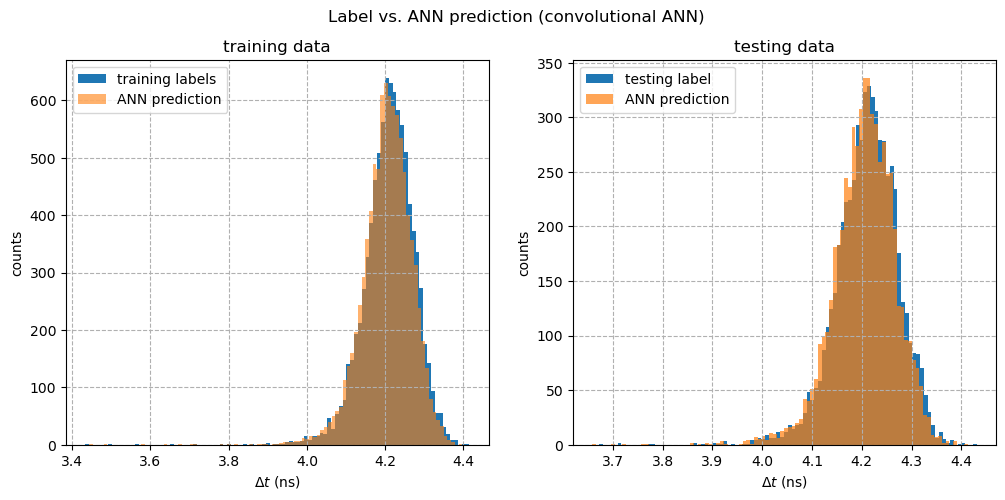

In [8]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
fig.suptitle('Label vs. ANN prediction (convolutional ANN)')
resultTrainingConv = modelConv.predict(training_signalData)[:,0]
ax[0].hist(training_timeLabel, bins = 100, label = 'training labels')
ax[0].hist(resultTrainingConv, bins = 100, alpha = 0.6, label = 'ANN prediction')
ax[0].set_ylabel('counts')
ax[0].set_xlabel('$\Delta t$ (ns)')
ax[0].set_title('training data')
ax[0].grid(ls = '--')
ax[0].legend()
resultTestingConv = modelConv.predict(testing_signalData)[:,0]
ax[1].hist(testing_timeLabel, bins = 100, label = 'testing label')
ax[1].hist(resultTestingConv, bins = 100, alpha = 0.7, label = 'ANN prediction')
ax[1].legend()
ax[1].set_ylabel('counts')
ax[1].set_xlabel('$\Delta t$ (ns)')
ax[1].grid(ls = '--')
ax[1].set_title('testing data');

In [9]:
resultTestingSATConv = []
for i in range(len(resultTestingConv)):
    resultTestingSATConv.append(- (testing_mcp[i] - resultTestingConv[i] - testing_t0mm[i]))
resultTrainingSATConv = []
for i in range(len(resultTrainingConv)):
    resultTrainingSATConv.append(- (training_mcp[i] - resultTrainingConv[i] - training_t0mm[i]))

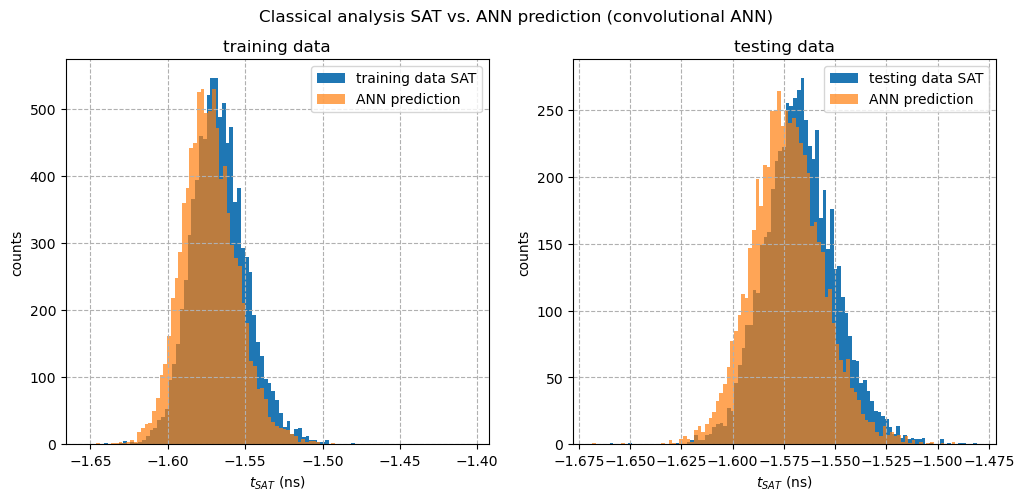

In [10]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
fig.suptitle('Classical analysis SAT vs. ANN prediction (convolutional ANN)')
ax[1].hist(testing_SAT, bins = 100, label = 'testing data SAT')
ax[1].hist(resultTestingSATConv, bins = 100, alpha = 0.7, label = 'ANN prediction')
ax[1].legend()
ax[1].set_ylabel('counts')
ax[1].set_xlabel('$t_{SAT}$ (ns)')
ax[1].set_title('testing data')
ax[1].grid(ls = '--')
ax[0].hist(training_SAT, bins = 100, label = 'training data SAT')
ax[0].hist(resultTrainingSATConv, bins = 100, alpha = 0.7, label = 'ANN prediction')
ax[0].legend()
ax[0].set_ylabel('counts')
ax[0].set_xlabel('$t_{SAT}$ (ns)')
ax[0].set_title('training data')
ax[0].grid(ls = '--')

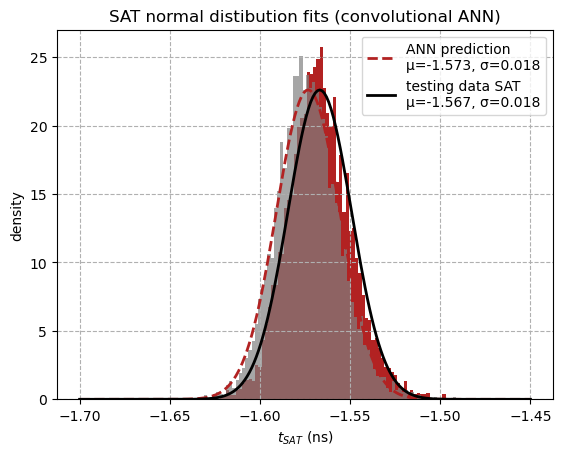

In [11]:
xmin = -1.7
xmax = -1.45
muTestingConv, stdTestingConv = norm.fit(resultTestingSATConv)
muSAT, stdSAT = norm.fit(testing_SAT)
xs = np.linspace(xmin, xmax, 200)
p1 = norm.pdf(xs, muTestingConv, stdTestingConv)
p2 = norm.pdf(xs, muSAT, stdSAT)
plt.plot(xs, p1, c = 'firebrick', linewidth=2, ls = '--', label=f'ANN prediction\nμ={muTestingConv:.3f}, σ={stdTestingConv:.3f}')
plt.plot(xs, p2, c = 'black', linewidth=2, label=f'testing data SAT\nμ={muSAT:.3f}, σ={stdSAT:.3f}')
plt.hist(testing_SAT, bins = 100, density = True, facecolor = 'firebrick')
plt.hist(resultTestingSATConv, bins = 100, alpha = 0.7, density = True, facecolor = 'gray')
plt.xlabel('$t_{SAT}$ (ns)')
plt.ylabel('density')
plt.title('SAT normal distibution fits (convolutional ANN)')
plt.legend()
plt.grid(ls = '--')

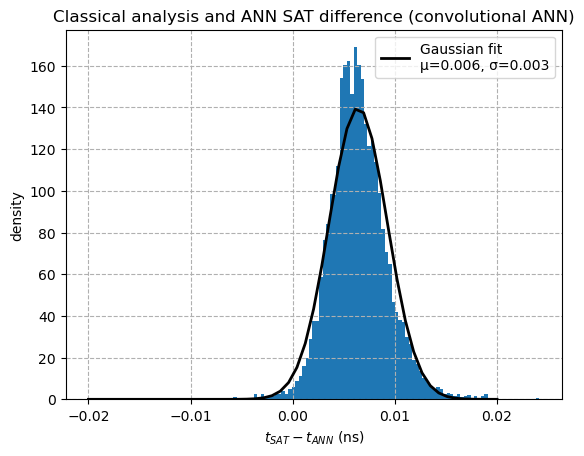

In [12]:
predictionErrorConv = testing_SAT-resultTestingSATConv
xmin = -0.02
xmax = 0.02
z_scores = np.abs((predictionErrorConv - np.mean(predictionErrorConv)) / np.std(predictionErrorConv))
trimmed_data = predictionErrorConv[z_scores < 3]  # Keep data within ~98.8%
mu, std = norm.fit(predictionErrorConv)
x = np.linspace(xmin, xmax, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label=f'Gaussian fit\nμ={mu:.3f}, σ={std:.3f}')
plt.hist(predictionErrorConv, bins = 100, density = True)
plt.xlabel('$t_{SAT}-t_{ANN}$ (ns)')
plt.ylabel('density')
plt.title('Classical analysis and ANN SAT difference (convolutional ANN)')
plt.legend()
plt.grid(ls = '--')

Treniranje jednostavne mreže i analiza podataka:

In [13]:
modelSimple.fit(training_signalData, training_timeLabel, epochs = 100, callbacks=[EarlyStoppingCallback()])

Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.0303
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0052
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0037
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0031
Epoch 6/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0028
Epoch 7/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025
Epoch 8/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0023
Epoch 9/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021
Epoch 10/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020
Epoch 11/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018
Epoch 12/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0018
Epoch 13/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015
Epoch 14/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015
Epoch 15/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1

286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


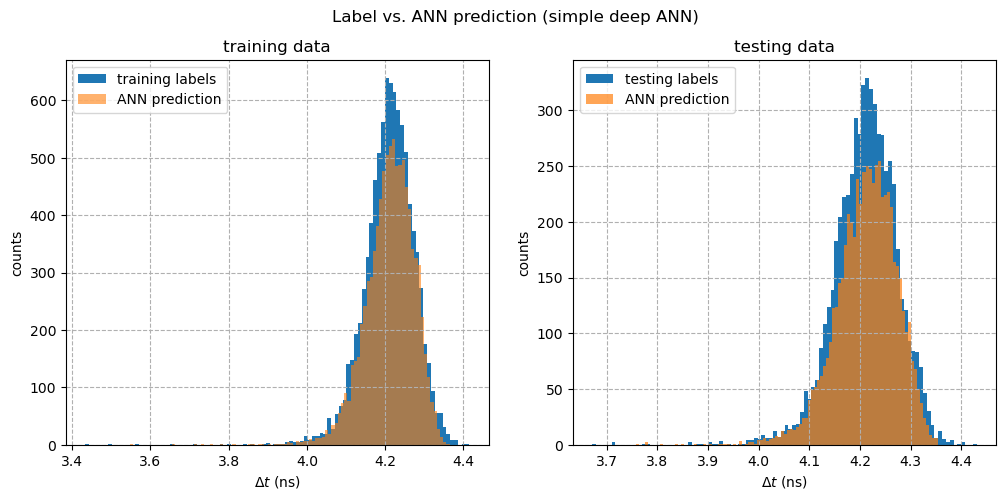

In [14]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
fig.suptitle('Label vs. ANN prediction (simple deep ANN)')
resultTrainingSimple = modelSimple.predict(training_signalData)[:,0]
ax[0].hist(training_timeLabel, bins = 100, label = 'training labels')
ax[0].hist(resultTrainingSimple, bins = 100, alpha = 0.6, label = 'ANN prediction')
ax[0].set_ylabel('counts')
ax[0].set_xlabel('$\Delta t$ (ns)')
ax[0].set_title('training data')
ax[0].grid(ls = '--')
ax[0].legend()
resultTestingSimple = modelSimple.predict(testing_signalData)[:,0]
ax[1].hist(testing_timeLabel, bins = 100, label = 'testing labels')
ax[1].hist(resultTestingSimple, bins = 100, alpha = 0.7, label = 'ANN prediction')
ax[1].legend()
ax[1].set_ylabel('counts')
ax[1].set_xlabel('$\Delta t$ (ns)')
ax[1].grid(ls = '--')
ax[1].set_title('testing data');

In [15]:
resultTestingSATSimple = []
for i in range(len(resultTestingSimple)):
    resultTestingSATSimple.append(- (testing_mcp[i] - resultTestingSimple[i] - testing_t0mm[i]))
resultTrainingSATSimple = []
for i in range(len(resultTrainingSimple)):
    resultTrainingSATSimple.append(- (training_mcp[i] - resultTrainingSimple[i] - training_t0mm[i]))

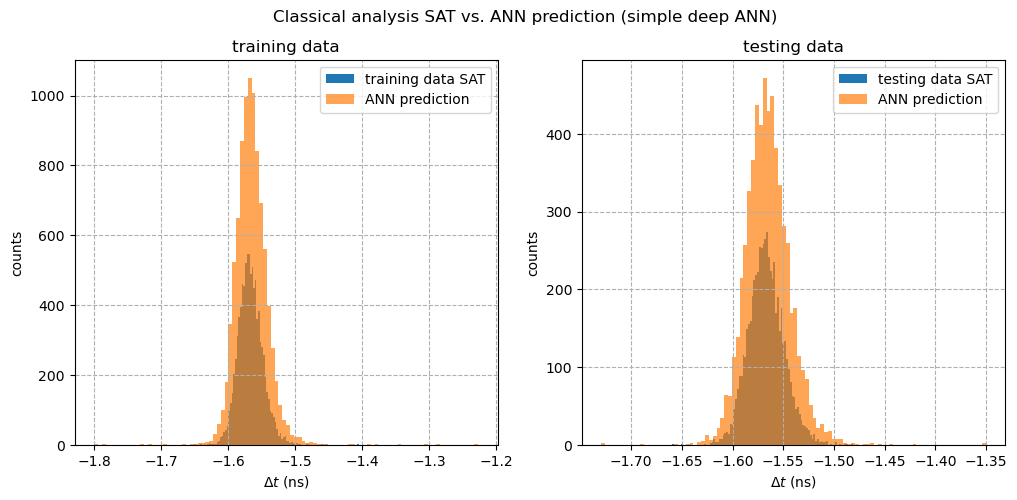

In [16]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
fig.suptitle('Classical analysis SAT vs. ANN prediction (simple deep ANN)')
ax[1].hist(testing_SAT, bins = 100, label = 'testing data SAT')
ax[1].hist(resultTestingSATSimple, bins = 100, alpha = 0.7, label = 'ANN prediction')
ax[1].legend()
ax[1].set_ylabel('counts')
ax[1].set_xlabel('$\Delta t$ (ns)')
ax[1].set_title('testing data')
ax[1].grid(ls = '--')
ax[0].hist(training_SAT, bins = 100, label = 'training data SAT')
ax[0].hist(resultTrainingSATSimple, bins = 100, alpha = 0.7, label = 'ANN prediction')
ax[0].legend()
ax[0].set_ylabel('counts')
ax[0].set_xlabel('$\Delta t$ (ns)')
ax[0].set_title('training data')
ax[0].grid(ls = '--')

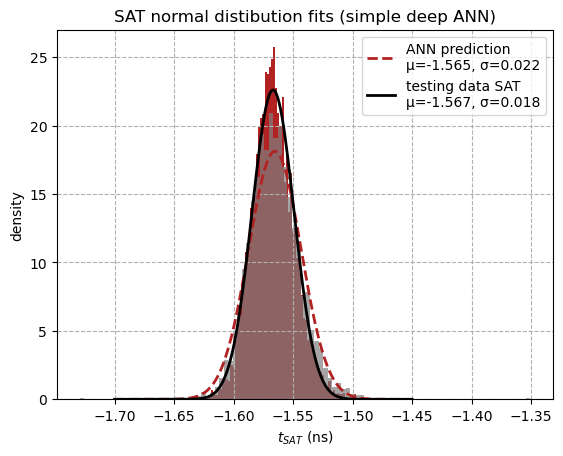

In [17]:
xmin = -1.7
xmax = -1.45
muTestingSimple, stdTestingSimple = norm.fit(resultTestingSATSimple)
muSAT, stdSAT = norm.fit(testing_SAT)
xs = np.linspace(xmin, xmax, 200)
p1 = norm.pdf(xs, muTestingSimple, stdTestingSimple)
p2 = norm.pdf(xs, muSAT, stdSAT)
plt.plot(xs, p1, c = 'firebrick', linewidth=2, ls = '--', label=f'ANN prediction\nμ={muTestingSimple:.3f}, σ={stdTestingSimple:.3f}')
plt.plot(xs, p2, c = 'black', linewidth=2, label=f'testing data SAT\nμ={muSAT:.3f}, σ={stdSAT:.3f}')
plt.hist(testing_SAT, bins = 100, density = True, facecolor = 'firebrick')
plt.hist(resultTestingSATSimple, bins = 100, alpha = 0.7, density = True, facecolor = 'gray')
plt.xlabel('$t_{SAT}$ (ns)')
plt.ylabel('density')
plt.title('SAT normal distibution fits (simple deep ANN)')
plt.legend()
plt.grid(ls = '--')

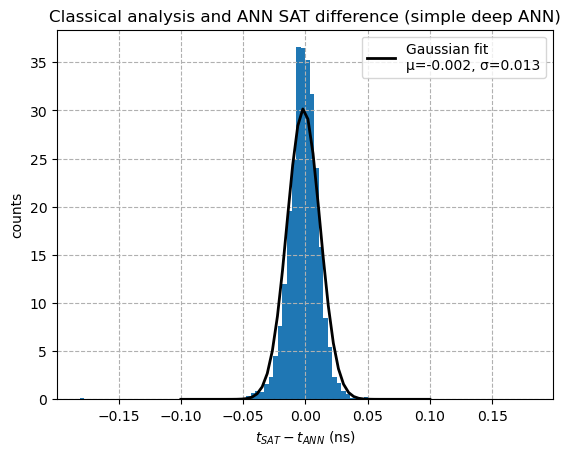

In [18]:
predictionErrorSimple = testing_SAT-resultTestingSATSimple
xmin = -0.1
xmax = 0.1
z_scores = np.abs((predictionErrorSimple - np.mean(predictionErrorSimple)) / np.std(predictionErrorSimple))
trimmed_data = predictionErrorSimple[z_scores < 3]  # Keep data within ~98.8%
mu, std = norm.fit(predictionErrorSimple)
x = np.linspace(xmin, xmax, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label=f'Gaussian fit\nμ={mu:.3f}, σ={std:.3f}')
plt.hist(predictionErrorSimple, bins = 100, density = True)
plt.xlabel('$t_{SAT}-t_{ANN}$ (ns)')
plt.ylabel('counts')
plt.title('Classical analysis and ANN SAT difference (simple deep ANN)')
plt.legend()
plt.grid(ls = '--')